In [1]:
import numpy as np  
import os 
from matplotlib import pyplot as plt 
import math

currentDir = os.getcwd()
firstPath = os.path.join(currentDir,"dataFirstMethod.txt")
secondPath = os.path.join(currentDir,'dataSecondMethod.txt')

In [2]:
def convertNumbersRA(inputString):
    prescalers = [15,15/60,15/3600] # Make them degrees, arcminutes,arcseconds
    finalDegree = 0
    for time, number in zip(inputString,prescalers):
        finalDegree += float(time)*number
    return finalDegree

def convertNumbersDELTA(inputString):
    prescalers = [1,1/60,1/3600] # Make them degrees, arcminutes,arcseconds
    finalDegree = 0
    for time, number in zip(inputString,prescalers):
        finalDegree += float(time)*number
    return finalDegree

In [3]:
firstMethodData = {"NAME":[],"RA":[],"DELTA":[]}
secondMethodData = {
    'PARALLAX' : [],
    'PARALLAX_ERROR' : [],
    'VELOCITY' : [],
    'VELOCITY_ERROR' : [],
    'MU_A_COS(DELTA)' : [],
    'MU_A_COS(DELTA)_ERROR' : [],
    'MU_DELTA' : [],
    'MU_DELTA_ERROR' : []
}
keysArray = ['PARALLAX',
    'PARALLAX_ERROR',
    'VELOCITY',
    'VELOCITY_ERROR', 
    'MU_A_COS(DELTA)',
    'MU_A_COS(DELTA)_ERROR',
    'MU_DELTA' ,
    'MU_DELTA_ERROR']

with open(firstPath, 'r') as file:
    line = file.readline()
    while line:
        currentLine = line.strip("\n").split(" ")
        RAString, DELTAString = currentLine[1:4] , currentLine[4:7] #Make all the angles into degrees
        firstMethodData["NAME"].append(currentLine[0])
        firstMethodData["RA"].append(convertNumbersRA(RAString))
        firstMethodData["DELTA"].append(convertNumbersDELTA(DELTAString))
        line = file.readline()
        
with open(secondPath, 'r') as file:
    for line in file:
        currentLine = line.strip("\n").split(" ")[1::] #Clear the line by ignoring the first elements that correspond to the name
        #print(currentLine)
        for index, value in enumerate(currentLine):
            trueValue,trueError = value.split('Â±')
            keyIdValue,keyIdError = keysArray[index*2],keysArray[index*2+1]
            #print(value,trueValue, trueError)
            secondMethodData[keyIdValue].append(float(trueValue))
            secondMethodData[keyIdError].append(float(trueError))
            
for keyToPop in keysArray[2::]:
    firstMethodData[keyToPop] = secondMethodData.pop(keyToPop)
secondMethodData['NAME'] = firstMethodData['NAME']


In [4]:
#The formula for finding the difference between a star (alpha,delta) and the convergent point(alpha_conv,delta_conv) is:
#cos(theta) = sin(delta)*sin(delta_c)+cos(delta)*cos(delta_c)*cos(alpha-alpha_conv)
def findAngleTheta(alpha,delta): #Takes as arguments the RA and DELTA values of the dict row and returns the assigned THETA angle in degrees
    alpha_conv,delta_conv = 96.6, 5.8
    degreeToRadians = math.pi/180
    part1 = math.sin(delta*degreeToRadians)*math.sin(delta_conv*degreeToRadians)
    part2 = math.cos(delta*degreeToRadians)*math.cos(delta_conv*degreeToRadians)*math.cos((alpha-alpha_conv)*degreeToRadians)
    return math.acos(part1 + part2)/degreeToRadians

def addThetaAngleColumn(dictionary): #Takes the dictionary of data and returns the array of all the THETA angles in degrees
    if 'THETA' in dictionary:
        return dictionary['THETA']
    deltaArray,alphaArray = dictionary['DELTA'],dictionary['RA']
    thetaArray = []
    for alpha,delta in zip(alphaArray,deltaArray):
        thetaArray.append(findAngleTheta(alpha,delta))
    return thetaArray

def addTheMuColumn(dictionary):
    if 'MU' in dictionary:
        return dictionary['MU']
    MU_DELTA, MU_A_COS = dictionary['MU_DELTA'], dictionary['MU_A_COS(DELTA)']
    MuArray = []
    for muDelta,muA in zip(MU_DELTA,MU_A_COS):
        MuArray.append(math.sqrt(muDelta**2 + muA**2))
    return MuArray   

def addTheDistanceColumn(dictionary):
    if 'DISTANCE' in dictionary:
        return dictionary['DISTANCE']
    thetaArray,muArray,velocityArray = dictionary['THETA'], dictionary['MU'], dictionary['VELOCITY']
    degreeToRadians = math.pi/180
    distanceArray = []
    for theta,mu,velocity in zip(thetaArray,muArray,velocityArray):
        distanceArray.append(1000*velocity*math.tan(theta*degreeToRadians)/(4.74*mu))
    return distanceArray

def addTheErrorColumn(dictionary):
    if 'ERROR_DISTANCE' in dictionary:
        return dictionary['ERROR_DISTANCE']
    xArray,errorxArray,yArray,erroryArray,muArray = dictionary['MU_A_COS(DELTA)'],dictionary['MU_A_COS(DELTA)_ERROR'],dictionary['MU_DELTA'],dictionary['MU_DELTA_ERROR'],dictionary['MU']
    muErrorArray,distanceErrorArray = [], []
    #Finding the mu error
    for x,errx,y,erry,mu in zip(xArray,errorxArray,yArray,erroryArray,muArray):
        muErrorArray.append(math.sqrt((x*errx)**2+(y*erry)**2)/mu)
    velArray,distanceArray,velocityErrorArray = dictionary['VELOCITY'], dictionary['DISTANCE'],dictionary['VELOCITY_ERROR']
    #Total error for second error
    for vel,velerr,mu,muerr,r in zip(velArray,velocityErrorArray,muArray,muErrorArray,distanceArray):
        distanceErrorArray.append(r*math.sqrt((velerr/vel)**2+(muerr/mu)**2))
    return distanceErrorArray
    

In [5]:
firstMethodData.update({'THETA': addThetaAngleColumn(firstMethodData)})
firstMethodData.update({'MU': addTheMuColumn(firstMethodData)})
firstMethodData.update({'DISTANCE': addTheDistanceColumn(firstMethodData)})
firstMethodData.update({'DISTANCE_ERROR':addTheErrorColumn(firstMethodData)})

In [18]:
firstMethodData.keys()

dict_keys(['NAME', 'RA', 'DELTA', 'VELOCITY', 'VELOCITY_ERROR', 'MU_A_COS(DELTA)', 'MU_A_COS(DELTA)_ERROR', 'MU_DELTA', 'MU_DELTA_ERROR', 'THETA', 'MU', 'DISTANCE', 'DISTANCE_ERROR'])

In [21]:
for index in range(len(firstMethodData['NAME'])):
    print(firstMethodData['NAME'][index], firstMethodData['RA'][index],firstMethodData['DELTA'][index], firstMethodData['THETA'][index])

13834 44.521166666666666 20.668805555555558 52.57330140110175
14838 47.906958333333336 19.726694444444444 49.28602404708215
18170 58.2915 17.327166666666667 39.16433036514141
18735 60.202875 18.194055555555554 37.59716778285854
19554 62.83416666666667 5.523027777777778 33.59733286808986
20205 64.94804166666667 15.627694444444446 32.56204379434104
20261 65.151 15.095500000000001 32.245657434729075
20400 65.514375 14.07725 31.678814240872647
20455 65.73345833333333 17.542583333333337 32.35860486247454
20542 66.02370833333333 17.444222222222223 32.06500463539908
20635 66.34208333333333 22.293972222222223 33.54580216833866
20711 66.576625 22.813694444444444 33.572569114687404
20713 66.586125 15.618333333333334 31.03304691382793
20842 67.003 21.62 32.70706781152692
20885 67.14345833333333 15.962222222222222 30.60904757782889
20889 67.153875 19.18052777777778 31.628231361701783
20894 67.16529166666666 15.870944444444445 30.563679413135116
20901 67.20875 13.047638888888889 29.85778486753339
2

In [6]:
def addSecondMethodDistance(dictionary): 
    if 'DISTANCE' in dictionary:
        return dictionary['DISTANCE']
    distanceArray,parallaxArray = [], dictionary['PARALLAX']
    for par in parallaxArray:
        distanceArray.append(1000/par)
    return distanceArray  

def addSecondMethodDistanceError(dictionary):
    if 'DISTANCE_ERROR' in dictionary:
        return dictionary['DISTANCE_ERROR']
    parallaxArray, parallaxErrorArray,distanceArray = dictionary['PARALLAX'],dictionary['PARALLAX_ERROR'],dictionary['DISTANCE']
    distanceErrorArray = []
    for par,parerror,dis in zip(parallaxArray, parallaxErrorArray,distanceArray):
        distanceErrorArray.append(dis*parerror/par)
    return distanceErrorArray
    

In [7]:
secondMethodData.update({'DISTANCE': addSecondMethodDistance(secondMethodData)})
secondMethodData.update({'DISTANCE_ERROR': addSecondMethodDistanceError(secondMethodData)})

In [8]:
def clearData(dictionaryFirstMethod,dictionarySecondMethod):
    threshold,center = 10 ,46.34
    totalData = {
        'NAME':[],
        'DISTANCE_FIRST':[],
        'DISTANCE_FIRST_ERROR':[],
        'DISTANCE_SECOND':[],
        'DISTANCE_SECOND_ERROR' : []
        }
    distArray1,distArray2 = dictionaryFirstMethod['DISTANCE'],dictionarySecondMethod['DISTANCE']
    for index, (starDist,starDist2) in enumerate(zip(distArray1,distArray2)):
        if (abs(starDist - center) < threshold) and (abs(starDist2 - center) < threshold): # we will require that by both methods the stars are in the center, as otherwise it will be unwise
            totalData['NAME'].append(dictionaryFirstMethod['NAME'][index])
            totalData['DISTANCE_FIRST'].append(dictionaryFirstMethod['DISTANCE'][index])
            totalData['DISTANCE_FIRST_ERROR'].append(dictionaryFirstMethod['DISTANCE_ERROR'][index])
            totalData['DISTANCE_SECOND'].append(dictionarySecondMethod['DISTANCE'][index])
            totalData['DISTANCE_SECOND_ERROR'].append(dictionarySecondMethod['DISTANCE_ERROR'][index])
    return totalData

def addDifferenceColumn(dictionary):
    if 'DIFFERENCE' in dictionary:
        return dictionary
    differenceArray, diffErrorArray = [], []
    dis1Array,dis2Array, err1Array, err2Array = dictionary['DISTANCE_FIRST'],dictionary['DISTANCE_SECOND'],dictionary['DISTANCE_FIRST_ERROR'],dictionary['DISTANCE_SECOND_ERROR']
    for dis1,dis2,err1,err2 in zip(dis1Array,dis2Array, err1Array, err2Array):
        differenceArray.append(dis1-dis2)
        diffErrorArray.append(err1+err2)
    return {'DIFFERENCE': differenceArray,'DIFFERENCE_ERROR': diffErrorArray}

def calculateAverage(valueArray,valueErrorArray,name):
    valueAverage, valueErrorAverage, size = 0, 0, len(valueArray)
    for val,err in zip(valueArray,valueErrorArray):
        valueAverage += val 
        valueErrorAverage += err
    print(f'The mean distance to the cluster using the '+ name +f" method is {valueAverage/size} ± {valueErrorAverage/size} pc")
    pass
    # return valueAverage/size, valueErrorAverage/size

In [9]:
totalData = clearData(firstMethodData,secondMethodData)
totalData.update(addDifferenceColumn(totalData))

In [10]:
calculateAverage(totalData["DISTANCE_FIRST"],totalData['DISTANCE_FIRST_ERROR'],'first')
calculateAverage(totalData["DISTANCE_SECOND"],totalData['DISTANCE_SECOND_ERROR'],'second')

The mean distance to the cluster using the first method is 44.45568396271792 ± 1.8275206846673697 pc
The mean distance to the cluster using the second method is 47.02007207663225 ± 2.0167075725224954 pc


In [11]:
RaArray, DeltaArray = [] , []
distance,distanceError = totalData['DISTANCE_FIRST'],totalData['DISTANCE_FIRST_ERROR']

for index, element1 in enumerate(firstMethodData['NAME']):
    for element in totalData['NAME']:
        if element1 == element:
            RaArray.append(firstMethodData['RA'][index])
            DeltaArray.append(firstMethodData['DELTA'][index])
            break 

In [12]:
def plot_points_and_circles(x, y, dis,error):
    fig, ax = plt.subplots()
    ax.set_aspect('equal', 'box')
    
    for i in range(len(x)):
        ax.plot(x[i], y[i]) 
        circle = plt.Circle((x[i], y[i]), dis[i]/100, color='white', fill=True)  #add the circles with the error bars
        errorCircle = plt.Circle((x[i],y[i]),dis[i]/75 + error[i]/5,color='r',fill=False)
        ax.add_artist(circle) 
        ax.add_artist(errorCircle)

    plt.xlabel('Right Ascension(degrees)')
    ax.invert_xaxis() #For convention, as Ra goes right to left
    plt.ylabel('Delta(degrees)')
    plt.title('The Hyades in the sky')
    plt.grid(True)
    plt.show()

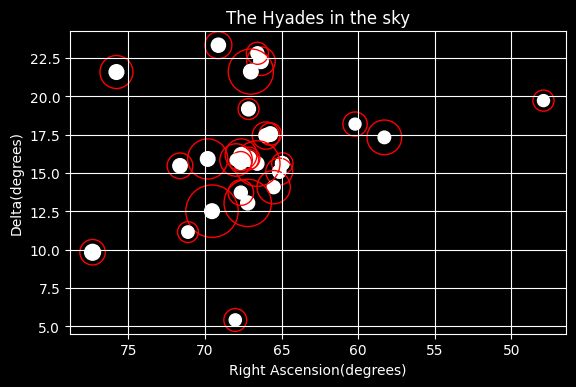

In [13]:
plt.style.use("dark_background")
plot_points_and_circles(RaArray,DeltaArray,distance,distanceError)